In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import statistics
# import time
# from scipy.stats import skewnorm
# from matplotlib.collections import PatchCollection
# from matplotlib.patches import Rectangle
# from matplotlib.markers import MarkerStyle

## Import the logs from .CSV and create DataFrame

In [87]:
logs_df = pd.read_csv('defectRemediation_log_simulation_vPrototype.csv', index_col='ID')
# logs_df['Date'] = pd.to_datetime(logs_df['Date'], format='%Y-%d-%m').dt.date
# logs_df['Timestamp'] = pd.to_datetime(logs_df['Timestamp'], format='%H:%M:%S').dt.time
# logs_df['Date'] = pd.to_datetime(logs_df['Date'], format='%Y-%d-%m')
logs_df['Timestamp'] = pd.to_datetime(logs_df['Timestamp'], format='%Y-%d-%m %H:%M:%S')
logs_df

,Defect_ID,Control_Type,State,Date,Timestamp
ID,,,,,
1,1,ACC03,new,2025-16-05,2025-05-16 00:05:31
2,2,ACC17,new,2025-16-05,2025-05-16 00:12:42
3,3,ACC28,new,2025-16-05,2025-05-16 00:13:44
4,1,ACC03,assign,2025-16-05,2025-05-16 00:18:57
5,1,ACC03,in-progress,2025-16-05,2025-05-16 00:22:43
...,...,...,...,...,...
112,29,ACC17,in-progress,2025-29-05,2025-05-29 12:05:29
113,27,ACC17,in-progress,2025-29-05,2025-05-29 13:47:03
114,29,ACC17,closed,2025-30-05,2025-05-30 09:58:24


In [88]:
hours = []
for row in logs_df.iterrows():
    hours.append(logs_df.loc[row[0]]['Timestamp'].hour)
    # logs_df[row]
# logs_df['Timestamp']
logs_df['Hour'] = hours
logs_df

,Defect_ID,Control_Type,State,Date,Timestamp,Hour
ID,,,,,,
1,1,ACC03,new,2025-16-05,2025-05-16 00:05:31,0
2,2,ACC17,new,2025-16-05,2025-05-16 00:12:42,0
3,3,ACC28,new,2025-16-05,2025-05-16 00:13:44,0
4,1,ACC03,assign,2025-16-05,2025-05-16 00:18:57,0
5,1,ACC03,in-progress,2025-16-05,2025-05-16 00:22:43,0
...,...,...,...,...,...,...
112,29,ACC17,in-progress,2025-29-05,2025-05-29 12:05:29,12
113,27,ACC17,in-progress,2025-29-05,2025-05-29 13:47:03,13
114,29,ACC17,closed,2025-30-05,2025-05-30 09:58:24,9


### Build incoming defects distributions from logs

In [89]:
# master dictionary with tracked empirical data to build distributions
empirical_dict = {}
incoming_dict = {}
control_types = logs_df['Control_Type'].unique()
for control_type in control_types:
    empirical_dict[control_type] = {'incoming_per_hour': [],
                                    'delta_new_assign': [],
                                    'delta_assign_inprogress': [],
                                    'delta_inprogress_closed': []
                                   }
    incoming_dict[control_type] = {}

In [90]:
# hours = list(range(0,24)) + [0] # list of hours from midnight to midnight
# hours = list(range(0,24))

# count no° of incoming defects per control type every hour per day WHERE STATE == NEW
# for day in logs_df["Date"].unique():
# sub_logs_df = logs_df.query('(Date == @day) and (State == "new")')
for control_type in control_types:
    sub_logs_df = logs_df.query('(Control_Type == @control_type) and (State == "new")')
    for day in logs_df["Date"].unique():
        sub_logs_df_date = sub_logs_df.query('Date == @day')['Hour'].value_counts()
        incoming_defects = [sub_logs_df_date.loc[i] if i in sub_logs_df_date.index else 0 for i in range(0,24)]
        incoming_dict[control_type].update({day: incoming_defects})
        empirical_dict[control_type]['incoming_per_hour'] = empirical_dict[control_type]['incoming_per_hour'] + incoming_dict[control_type][day]
    
# incoming_dict
len(empirical_dict['ACC03']['incoming_per_hour'])

288

## Creating Delta table to track time b/w state changes

#### If Delta table already exists, skip the next block; otherwise initialize the empty Delta table:

In [91]:
deltas_df = pd.DataFrame(columns=['Defect_ID','Control_Type','Delta_New_Assign','Delta_Assign_InProgress','Delta_InProgress_Closed'])

In [92]:
# timestamp_new = logs_df.loc[(logs_df['Defect_ID']==13) & (logs_df['State']=='new')]['Timestamp'].iloc[0]
# timestamp_assign = logs_df.loc[(logs_df['Defect_ID']==13) & (logs_df['State']=='assign')]['Timestamp'].iloc[0]
# delta_new_assign = timestamp_assign - timestamp_new
# delta_new_assign

In [93]:
try: # deltas_df contains some entries, add onto it
    Last_ID_processed = deltas_df.index[-1]
    index = Last_ID_processed + 1
except IndexError: # deltas_df is empty, start from beginning
    index = 0 

for defect_id in logs_df['Defect_ID'].unique():
    #### Recover timestamps for each state change ####
    timestamp_new = logs_df.loc[(logs_df['Defect_ID']==defect_id) & (logs_df['State']=='new')]['Timestamp'].iloc[0] # OR logs_df.query('(Defect_ID == defect_id) and (State == "new")')['Timestamp'].iloc[0]
    timestamp_assign = logs_df.loc[(logs_df['Defect_ID']==defect_id) & (logs_df['State']=='assign')]['Timestamp'].iloc[0]
    timestamp_inprogress = logs_df.loc[(logs_df['Defect_ID']==defect_id) & (logs_df['State']=='in-progress')]['Timestamp'].iloc[0]
    timestamp_closed = logs_df.loc[(logs_df['Defect_ID']==defect_id) & (logs_df['State']=='closed')]['Timestamp'].iloc[0]

    # time between assign and new (hrs)
    delta_new_assign = timestamp_assign - timestamp_new
    delta_new_assign = round(delta_new_assign.total_seconds()/3600, 3)
    
    # time between in-progress and assign (hrs)
    delta_assign_inprogress = timestamp_inprogress - timestamp_assign
    delta_assign_inprogress = round(delta_assign_inprogress.total_seconds()/3600, 3)
    
    # time between closed and in-progress (hrs)
    delta_inprogress_closed = timestamp_closed - timestamp_inprogress
    delta_inprogress_closed = round(delta_inprogress_closed.total_seconds()/3600, 3)

    # append row to df and iterate index
    control_type = logs_df.loc[logs_df['Defect_ID'] == defect_id].iloc[0]['Control_Type']
    deltas_df.loc[index] = [defect_id, control_type, delta_new_assign, delta_assign_inprogress, delta_inprogress_closed]
    index += 1


In [94]:
deltas_df

,Defect_ID,Control_Type,Delta_New_Assign,Delta_Assign_InProgress,Delta_InProgress_Closed
0,1,ACC03,0.224,0.063,0.204
1,2,ACC17,0.501,0.503,0.779
2,3,ACC28,1.500,1.594,1.067
3,4,AUTH18,1.039,0.229,1.603
4,5,ACC03,0.845,0.466,0.731
5,6,AUTH42,0.378,0.029,0.092
6,7,ACC17,1.597,0.052,0.047
7,8,ACC03,0.329,0.206,2.983
8,9,ACC03,0.271,3.382,4.347
9,10,ACC03,1.506,2.044,2.186


In [95]:
deltas_df.groupby('Control_Type')[['Delta_New_Assign']].mean()

,Delta_New_Assign
Control_Type,
ACC03,9.583000
ACC17,4.886000
ACC28,3.209333
AUTH18,22.282000
AUTH42,17.168800


### Build time b/w state changes distributions from Delta table

In [96]:
deltas_df

,Defect_ID,Control_Type,Delta_New_Assign,Delta_Assign_InProgress,Delta_InProgress_Closed
0,1,ACC03,0.224,0.063,0.204
1,2,ACC17,0.501,0.503,0.779
2,3,ACC28,1.500,1.594,1.067
3,4,AUTH18,1.039,0.229,1.603
4,5,ACC03,0.845,0.466,0.731
5,6,AUTH42,0.378,0.029,0.092
6,7,ACC17,1.597,0.052,0.047
7,8,ACC03,0.329,0.206,2.983
8,9,ACC03,0.271,3.382,4.347
9,10,ACC03,1.506,2.044,2.186


In [97]:
for control_type in control_types:
    empirical_dict[control_type]['delta_new_assign'].extend(deltas_df.query('Control_Type == @control_type')['Delta_New_Assign'].to_list())
    empirical_dict[control_type]['delta_assign_inprogress'].extend(deltas_df.query('Control_Type == @control_type')['Delta_Assign_InProgress'].to_list())
    empirical_dict[control_type]['delta_inprogress_closed'].extend(deltas_df.query('Control_Type == @control_type')['Delta_InProgress_Closed'].to_list())

In [98]:
empirical_dict

{'ACC03': {'incoming_per_hour': [1,
   0,
   1,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   2,
   0,
   0,
   1,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   4,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   1,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0

#### Create histograms from empirical_dict

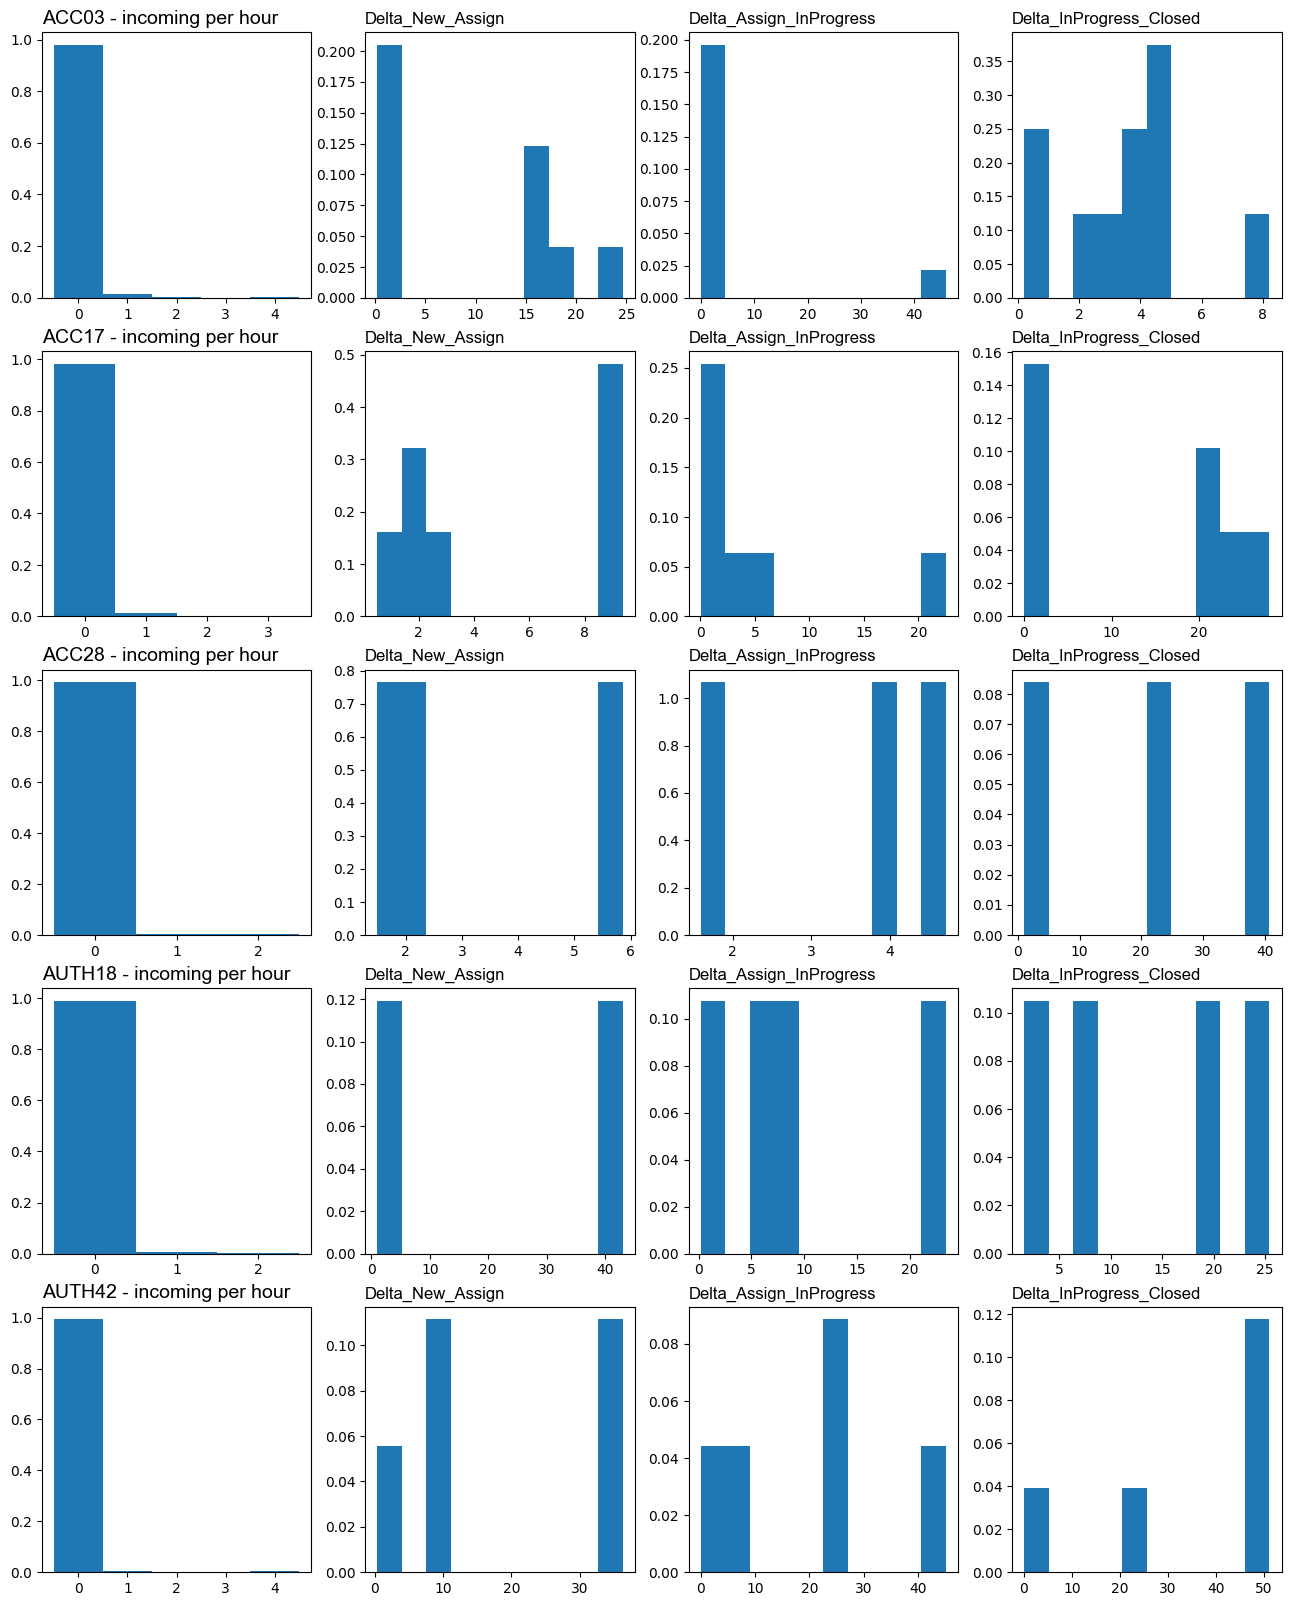

In [122]:
csfont = {'fontname':'Arial'}
fig, axs = plt.subplots (len(empirical_dict.keys()), 4, figsize=(16,20))
for index, value in enumerate(empirical_dict.keys()):
    data = np.array(empirical_dict[value]['incoming_per_hour'])
    unique_values = np.unique(data)
    if np.all(unique_values) == 0:
        d = 1
    else:
        d = np.diff(unique_values).min()
    left_of_first_bin = data.min() - float(d)/2
    right_of_last_bin = data.max() + float(d)/2
    axs[index][0].hist(data, np.arange(left_of_first_bin, right_of_last_bin + d, d), density=True)
    axs[index][0].set_title(f'{value} - incoming per hour', loc='left', fontsize=14, **csfont)
    axs[index][1].hist(empirical_dict[value]['delta_new_assign'], density=True)
    axs[index][2].hist(empirical_dict[value]['delta_assign_inprogress'], density=True)
    axs[index][3].hist(empirical_dict[value]['delta_inprogress_closed'], density=True)

    axs[index][1].set_title('Delta_New_Assign', loc='left', fontsize=12, **csfont)
    axs[index][2].set_title('Delta_Assign_InProgress', loc='left', fontsize=12, **csfont)
    axs[index][3].set_title('Delta_InProgress_Closed', loc='left', fontsize=12, **csfont)


plt.show()

## Simulated Delta table based on empirical histograms

In [123]:
projection_dict = {}
t_end = 50 # duration of the simulation, in (hrs)
for control_type in empirical_dict.keys():
    #### first sample how many defects were generated in t_end from empirical data ####
    sampled_values_incoming = np.random.choice(empirical_dict[control_type]['incoming_per_hour'], size=t_end, replace=True)
    nonzero_incoming_indices = np.nonzero(sampled_values_incoming) # indices of nonzero values in sampled_values_incoming
    nonzero_values_count = nonzero_incoming_indices[0].size

    #### assign a defect_ID to each generated defect ####
    defect_IDs = np.random.randint(1,1000000000, size=nonzero_values_count)
    defect_IDs = ['ID_' + str(defect_IDs[i]) for i in range(nonzero_values_count)] 

    #### sample time deltas for each generated defect from empirical data ####
    sampled_delta_new_assign = np.random.choice(empirical_dict[control_type]['delta_new_assign'], size=nonzero_values_count, replace=True)
    sampled_delta_assign_inprogress = np.random.choice(empirical_dict[control_type]['delta_new_assign'], size=nonzero_values_count, replace=True)
    sampled_delta_inprogress_closed = np.random.choice(empirical_dict[control_type]['delta_new_assign'], size=nonzero_values_count, replace=True)

    #### add generated defects to dictionary - to be turned into pandas df ####
    for i in range(nonzero_values_count):
        projection_dict[defect_IDs[i]] = {'Control_Type': control_type,
                                          'Delta_New_Assign': sampled_delta_new_assign[i],
                                          'Delta_Assign_InProgress': sampled_delta_assign_inprogress[i],
                                          'Delta_InProgress_Closed': sampled_delta_inprogress_closed[i]}

projection_dict
pd.DataFrame.from_dict(projection_dict, orient='index')

,Control_Type,Delta_New_Assign,Delta_Assign_InProgress,Delta_InProgress_Closed
ID_798683527,ACC03,0.845,0.271,0.271
ID_209912859,ACC03,1.506,0.329,15.869
ID_746713518,ACC17,1.504,1.504,9.149
ID_434819395,ACC17,2.794,9.149,9.376
ID_736474576,AUTH18,42.986,42.981,2.122


In [115]:
pd.DataFrame.from_dict(projection_dict, orient='index')

,Control_Type,Delta_New_Assign,Delta_Assign_InProgress,Delta_InProgress_Closed
ID_173101809,ACC03,24.622,16.184,1.506
ID_439632139,ACC17,1.504,1.504,0.501
ID_877938216,AUTH18,42.981,2.122,42.986
ID_33078502,AUTH18,42.981,42.986,42.986
ID_662638974,AUTH42,8.087,36.294,0.378
